# Setup

In [499]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import requests
import sys
import time
import random
import traceback
import shelve
import plotly.plotly as py # online
#import plotly.offline as py # offline
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
import matplotlib.pyplot as plt
%matplotlib inline
from gurobipy import *
from math import sqrt

# Get Historical Currency Data

In [500]:
# Modified the code from https://github.com/lagerfeuer/cryptocompare/blob/master/cryptocompare/cryptocompare.py

# API
URL_HIST_PRICE_DAILY = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}'
URL_COIN_LIST = 'https://www.cryptocompare.com/api/data/coinlist/'
CURR = 'USD'

def query_cryptocompare(url,errorCheck=True):
    try:
        response = requests.get(url).json()
    except Exception as e:
        print('Error getting coin information. %s' % str(e))
        return None
    if errorCheck and (response.get('Response') == 'Error'):
        print('[ERROR] %s' % response.get('Message'))
        return None
    return response

def get_coin_list(format=False):
    response = query_cryptocompare(URL_COIN_LIST, False)['Data']
    if format:
        return list(response.keys())
    else:
        return response

def get_historical_price_daily(coin, curr=CURR, days=10):
    return query_cryptocompare(URL_HIST_PRICE_DAILY.format(coin, curr, int(days)))

In [467]:
#coin_list_full = get_coin_list()
#len(coin_list_full.keys())

2319

In [501]:
coin_list = ['ETH','BTC','LTC', 'XRP', 'ETC','XMR','DASH','MAID','REP', 'XLM']

# crypto_data = dict()
# for coin in coin_list:
#     try:
#         crypto_data[coin] = get_historical_price_daily(coin, days=365)
#         time.sleep(1)
#     except Exception:
#         traceback.print_exc()
#         time.sleep(30)
        
# with shelve.open('shelf') as db:
#     db['crypto_data'] = crypto_data

In [469]:
# with shelve.open('shelf') as db:
#     db['crypto_data'] = crypto_data

In [502]:
# Open shelved data
with shelve.open('shelf') as db:
    crypto_data = db['crypto_data']

# Calculate Daily returns and covariances

In [503]:
data = dict()

for key, response in crypto_data.items():
    df = pd.DataFrame(response['Data'])
    df = df.set_index(pd.to_datetime(df['time'],unit='s')).drop(columns='time')['close']
    df.name = 'Close'
    data[key] = pd.DataFrame(df)

In [504]:
for k, m in data.items():
    m['return'] = (m['Close'] - m['Close'].shift(1)) / m['Close'].shift(1)

In [505]:
random.seed(1)
n_subset = len(data)
    
# smaller subset for testing
d2 = {k: data[k] for k in random.sample([key for key, value in data.items()],n_subset)}
returns = pd.concat([x['return'].fillna(0).replace(np.inf, 0) for x in d2.values()], axis=1,
                    keys=d2.keys())

# drop columns if they are all NaN
returns = returns.drop(returns.columns[~returns.notnull().any()], axis=1)

cov_matrix = returns.cov()
means = returns.mean()
returns.columns

Index(['LTC', 'BTC', 'ETC', 'ETH', 'XRP', 'XMR', 'MAID', 'XLM', 'REP', 'DASH'], dtype='object')

In [506]:
returns

,LTC,BTC,ETC,ETH,XRP,XMR,MAID,XLM,REP,DASH
time,,,,,,,,,,
2017-03-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-03-12,0.018421,0.038916,0.021739,0.086713,0.011200,0.154372,0.000000,0.063817,0.267581,0.047822
2017-03-13,0.126615,0.010677,0.163121,0.220506,0.018987,0.094083,0.000000,0.046406,0.041949,-0.018282
2017-03-14,-0.043578,0.003998,0.006098,0.004569,-0.007764,-0.058410,0.000000,-0.017307,0.102597,0.174839
2017-03-15,0.021583,0.008277,0.072727,0.230931,-0.021909,0.109707,0.000000,0.066593,0.166078,0.094766
2017-03-16,0.016432,-0.064264,0.175141,0.293633,0.008000,0.154244,0.000000,-0.127451,0.008081,-0.067813
2017-03-17,-0.030023,-0.086258,-0.168269,-0.022632,-0.052381,-0.014350,0.000000,0.045535,-0.258517,0.100905
2017-03-18,-0.035714,-0.093617,-0.063584,-0.235612,0.152429,-0.117379,0.000000,0.121606,-0.114865,0.103735
2017-03-19,-0.017284,0.052729,0.197531,0.268235,-0.027616,0.128351,0.000000,-0.142209,0.221374,-0.001379


In [507]:
means

LTC     0.014739
BTC     0.007218
ETC     0.011628
ETH     0.012355
XRP     0.021774
XMR     0.011504
MAID    0.002374
XLM     0.023045
REP     0.009638
DASH    0.008104
dtype: float64

In [477]:
# plotly
returns.iplot(filename='pred460_crypto_returns',online=True)

In [480]:
# # plotly
cov_matrix.iplot(kind='heatmap', filename='pred460_crypto_heatmap', online=True)

In [508]:
def random_portfolio(returns, means):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    k = np.random.rand(len(means))
    p = np.asmatrix(means)
    w = np.asmatrix(k / sum(k))
    C = np.asmatrix(cov_matrix)
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [509]:
n_portfolios = 10000
mns, stds = np.column_stack([
    random_portfolio(returns, means) 
    for _ in range(n_portfolios)
])

Text(0.5,1,'Mean and standard deviation of daily returns for randomly generated portfolios')

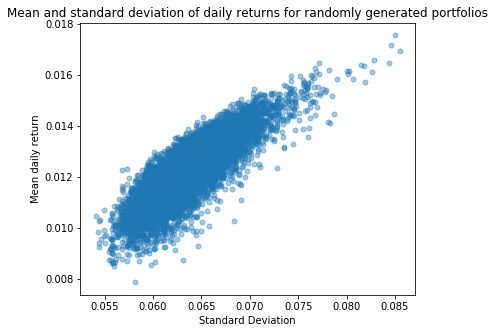

In [510]:
fig = plt.figure()
fig.set_size_inches(6, 5)
plt.plot(stds, mns, 'o', markersize=5, alpha=0.4)
plt.xlabel('Standard Deviation')
plt.ylabel('Mean daily return')
plt.title('Mean and standard deviation of daily returns for randomly generated portfolios')
#py.iplot_mpl(fig, filename='pred460_crypto_mean_std', strip_style=True) # online
#py.iplot_mpl(fig, strip_style=True) # offline

# Optimization

In [511]:
# based on example from http://www.gurobi.com/documentation/7.5/examples/portfolio_py.html#subsubsection:portfolio.py
stock_volatility = returns.std()
stock_return = returns.mean()

In [512]:
# Create an empty model
m = Model('portfolio')

In [513]:
# Add a variable for each stock
stocks = list(stock_volatility.index)
vars = pd.Series(m.addVars(stocks, name=stocks), index=stocks)

In [514]:
# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks.
sigma = cov_matrix
portfolio_risk = sigma.dot(vars).dot(vars)

In [515]:
m.setObjective(portfolio_risk, GRB.MINIMIZE)

In [516]:
# Fix budget with a constraint
m.addConstr(vars.sum() == 1, 'budget')

# Optimize model to find the minimum risk portfolio
m.setParam('OutputFlag', 0)
m.optimize()

In [517]:
# Create an expression representing the expected return for the portfolio
portfolio_return = stock_return.dot(vars)

# Display minimum risk portfolio
print('Minimum Risk Portfolio:\n')
for v in vars:
    if v.x > 0:
        print('\t%s\t: %g' % (v.varname, v.x))
minrisk_volatility = sqrt(portfolio_risk.getValue())
print('\nVolatility      = %g' % minrisk_volatility)
minrisk_return = portfolio_return.getValue()
print('Expected Return = %g' % minrisk_return)

Minimum Risk Portfolio:

	LTC	: 8.14799e-07
	BTC	: 0.572576
	ETC	: 6.82929e-08
	ETH	: 0.109035
	XRP	: 0.0388385
	XMR	: 9.9466e-09
	MAID	: 0.117862
	XLM	: 1.6999e-07
	REP	: 1.66961e-06
	DASH	: 0.161686

Volatility      = 0.0496372
Expected Return = 0.00791584


In [518]:
min_risk_vars = pd.Series(data=[v.x for v in vars if v.x > 0], index=[v.varname for v in vars if v.x > 0]).sort_values(ascending=False)
min_risk_vars.iplot(kind='bar',colorscale='ggplot', title='Minimum Risk Portfolio', online=False, filename='pred460_crypto_min_risk_portfolio')

In [519]:
# Add (redundant) target return constraint
target = m.addConstr(portfolio_return == minrisk_return, 'target')

In [520]:
def sharpe_ratio(mean, sd, riskfree=0.0):
    return ((mean - riskfree) / sd)

In [521]:
# Solve for efficient frontier by varying target return
max_sharpe_return = -np.Inf
max_sharpe_volitility = -np.Inf
max_sharpe_a = -np.Inf
max_sharpe_vars = pd.Series()
frontier = pd.Series()
for r in np.linspace(stock_return.min(), stock_return.max(), 100):
    target.rhs = r
    m.optimize()
    frontier.loc[sqrt(portfolio_risk.getValue())] = r
    a = sharpe_ratio(portfolio_return.getValue(), portfolio_risk.getValue())
    if a > max_sharpe_a:
        max_sharpe_a = a
        max_sharpe_return = portfolio_return.getValue()
        max_sharpe_volitility = sqrt(portfolio_risk.getValue())
        max_sharpe_vars = pd.Series(data=[v.x for v in vars if v.x > 0], index=[v.varname for v in vars if v.x > 0])

In [522]:
max_sharpe_vars.sort_values(ascending=False).iplot(kind='bar',colorscale='ggplot', title='Max Sharpe Ratio Portfolio', online=True, filename='pred460_crypto_max_sharpe_portfolio')

In [496]:
b = pd.concat({'Maximum Sharpe Ratio Portfolio':max_sharpe_vars,'Minimum Risk Portfolio':min_risk_vars}, 
              axis=1).sort_values('Maximum Sharpe Ratio Portfolio',ascending=False)
b.iplot(kind='bar', filename='pred460_crypto_portfolio_options_bar', online=True)

In [523]:
# Simulated sharpe ratio
s = pd.DataFrame(data={'sd': [float(x) for x in stds], 'mean': [float(x) for x in mns]}, index=range(len(mns)))
s['sharpe_ratio'] = s.apply(lambda row: sharpe_ratio(row['mean'], row['sd']), axis=1)
max_sharpe = s.loc[s['sharpe_ratio'].idxmax()]
s.head()

,mean,sd,sharpe_ratio
0,0.013880,0.068976,0.201228
1,0.009981,0.056833,0.175612
2,0.013351,0.063016,0.211861
3,0.013069,0.068882,0.189731
4,0.012673,0.063774,0.198721


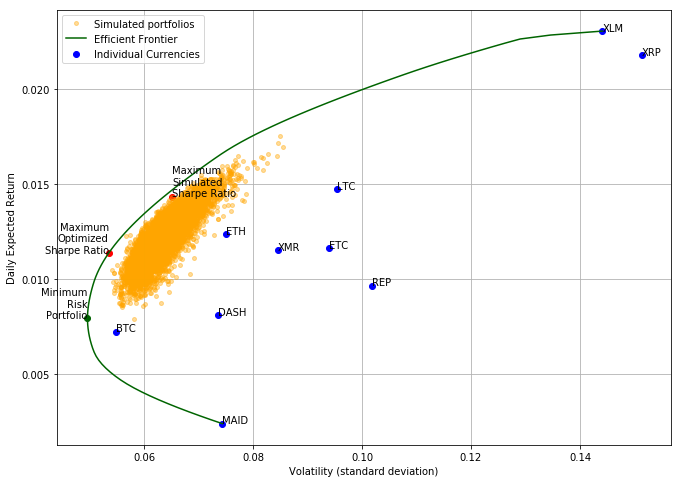

In [528]:
# Plot volatility versus expected return for individual stocks
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(11,8)

# Plot volatility versus expected return for random portolios
plt.plot(stds, mns, 'o', markersize=4, alpha=0.4, color='orange', label='Simulated portfolios')

ax.scatter(x=stock_volatility, y=stock_return,
           color='Blue', label='Individual Currencies')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (stock_volatility[i], stock_return[i]))

# Plot max sharpe ratio from optimization
ax.scatter(x=max_sharpe_volitility, y=max_sharpe_return, color='red')
ax.annotate('Maximum\nOptimized\nSharpe Ratio', (max_sharpe_volitility, max_sharpe_return),
            horizontalalignment='right')

# Plot max sharpe ratio from simulations
ax.scatter(x=max_sharpe['sd'], y=max_sharpe['mean'], color='red')
ax.annotate('Maximum\nSimulated\nSharpe Ratio', (max_sharpe['sd'], max_sharpe['mean']),
            horizontalalignment='left')

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
frontier.plot(color='DarkGreen', label='Efficient Frontier', ax=ax)


# Format and display the final plot
#ax.axis([0.005, 0.045, -0.001, 0.004])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Daily Expected Return')
ax.legend()
ax.grid()
plt.show()